# Here we make a Random Forest Model For Synechococcus


In [1]:
# Set a working directory
#!pip install GitPython
import git
import os

repo = git.Repo('.', search_parent_directories=True)


os.chdir(repo.working_tree_dir)

### Running the model prep notebook

In [2]:
# Running model preperation notebook that has a function we need to call
#%run '/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/python/04_Populations-model-fitting/01_model-preparation.ipynb'
%run 'python/04_Populations-model-fitting/01_model-preparation.ipynb'


In [3]:
#loading packages for random forest modeling

from sklearn.model_selection import train_test_split
import joblib

### First we are making a graph to determine the best testing to training ratio 

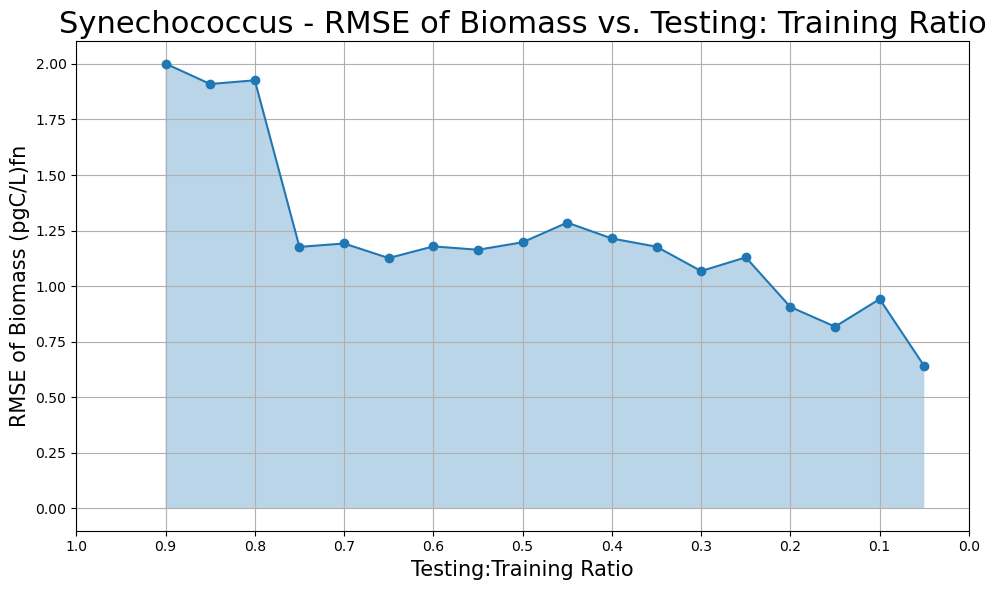

In [4]:
#using a function defined in the model preparation notebook
RMSEs = testing_training_ratio(features = features_syn, labels = labels_syn,
                               feature_list=feature_list_syn, title_prefix='Synechococcus')

## RF Regressor for Synechococcus

In [5]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets"
train_features, test_features, train_labels, test_labels = train_test_split(features_syn, labels_syn, test_size = 0.75, random_state=42)

In [6]:
# Looking at the shape of the features and labels to see if they match up
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (728, 22)
Training Labels Shape: (728,)
Testing Features Shape: (2185, 22)
Testing Labels Shape: (2185,)


/Users/stlp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/stlp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/stlp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


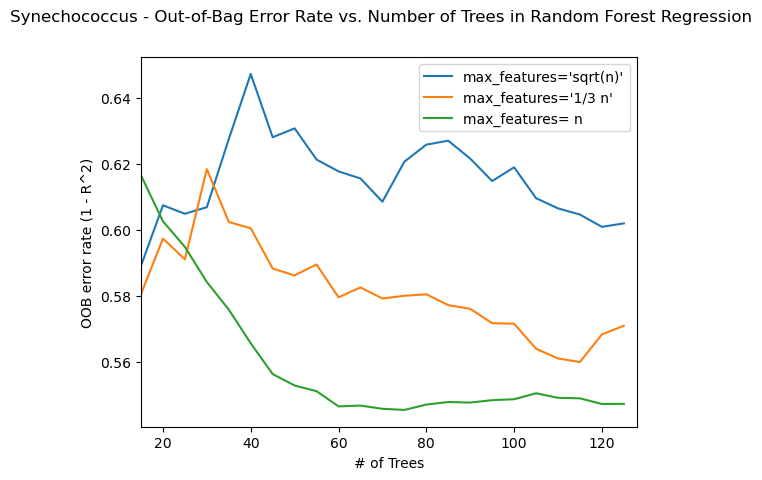

In [7]:
plot_oob_error_vs_num_trees(train_features, train_labels, title_prefix="Synechococcus")

In [8]:
# We are using a regressor RF model because we are predicting on continous values
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, max_features=1.0, random_state=42)
# Use the Training data to build the model
rf.fit(train_features, train_labels)
#saving the model
#joblib.dump(rf, "/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/RF_models/syn_random_forest.joblib")
joblib.dump(rf, "RF_models/syn_random_forest.joblib")


['RF_models/syn_random_forest.joblib']

### Predicting and Testing for Synechococcus

In [9]:
# Convert test_features to a DataFrame
test_features_df = pd.DataFrame(test_features, columns=feature_list_syn)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Create a new Series with predicted values and index from test_features_df
predic_biomass = pd.Series(predictions, index=test_features_df.index)

# Assign the new Series to the DataFrame using .loc
test_features_df.loc[:, 'Prediction'] = predic_biomass

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

# Finding the root mean square error (RMSE)
from sklearn.metrics import mean_squared_error
# RMSE give realtively high weight to large errors 
RMSE = mean_squared_error(test_labels, predictions, squared=False) #setting squared=False gives us RMSE not MSE


# Calculate the percentage of RMSE
range_target = test_labels.max() - test_labels.min()
percentage_RMSE = (RMSE / range_target) * 100

print('Root Mean Squared Error:', round(RMSE, 2), 'pgC per L.')
print('Percentage of RMSE:', round(percentage_RMSE, 2), '%')


Mean Absolute Error: 0.56 pgC per L.
Root Mean Squared Error: 1.18 pgC per L.
Percentage of RMSE: 2.27 %


In [10]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_syn, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

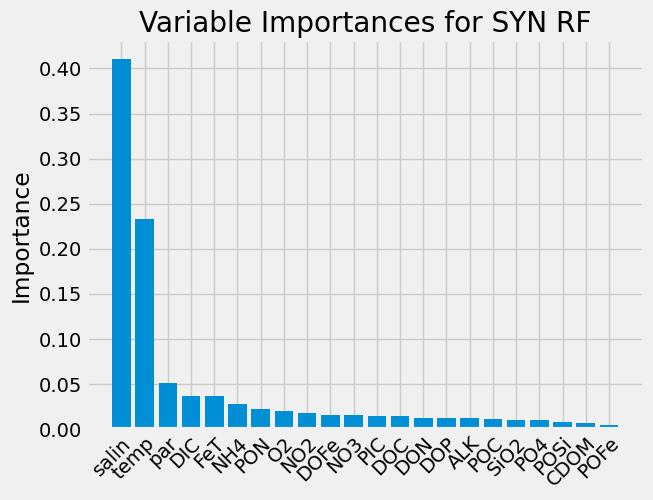

In [11]:
feature_importance = pd.DataFrame(rf.feature_importances_, index=feature_list_syn).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=feature_importance.index,height=feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(feature_importance.index, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for SYN RF');

In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, test_features, test_labels, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.DataFrame(result.importances_mean, index=feature_list_pro).sort_values(by=0, ascending=False)
forest_importances.to_csv('data/modified/syn_permutation_importance.csv', index=False)


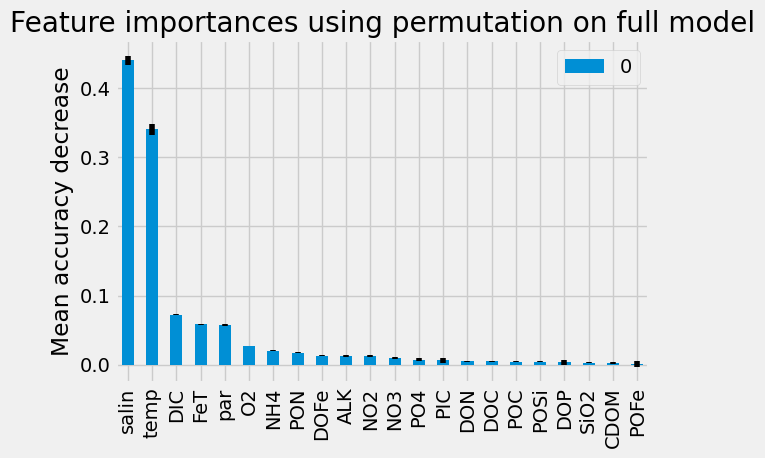

In [13]:


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

/var/folders/7z/m6zcyv9d6vvdh902wbc6r4z40000gn/T/ipykernel_64826/1153338531.py:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=test_labels, y=predictions, shade=True, cmap="Reds", ax=ax2)


Text(0.5, 1.0, 'Synechococcus')

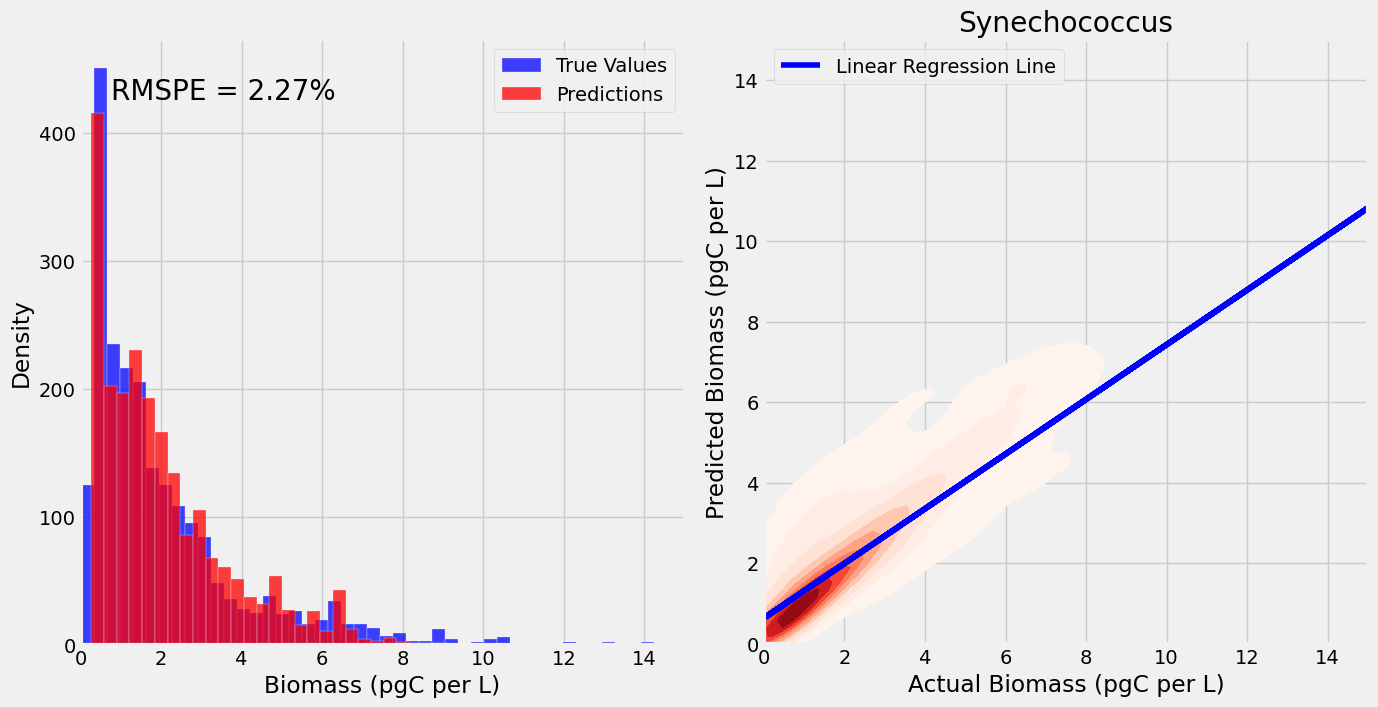

In [14]:
# Call the function and store the figure and axes objects
# Assuming plot_model_predictions() generates a plot and returns the figure and axes objects
fig, axs = plot_model_predictions()
axs[0].set_xlim(0,15)
axs[1].set_xlim(0,15)
axs[1].set_ylim(0,15)
axs[1].set_title('Synechococcus')

/var/folders/7z/m6zcyv9d6vvdh902wbc6r4z40000gn/T/ipykernel_64826/3857076419.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=test_labels, y=predictions, shade=True, cmap="Reds", ax=ax)


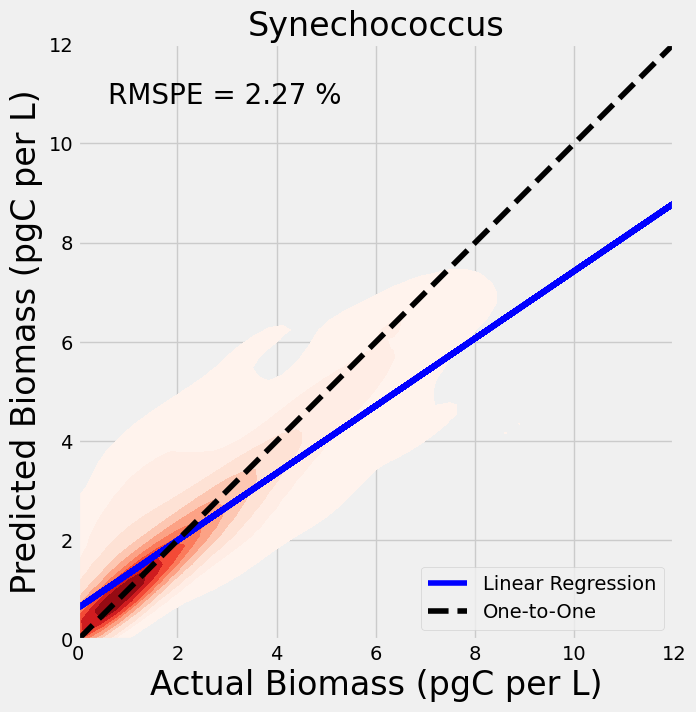

In [15]:
# Call the function and store the figure and axes objects
# Assuming plot_model_predictions_density() generates a plot and returns the figure and axes objects
fig, ax = plot_model_predictions_density()



# Display Legend
ax.legend(loc="lower right")

ax.set_xlim(0,12)
ax.set_ylim(0,12)
# Set the title for the single subplot
ax.set_title('Synechococcus', fontsize=24)

# Display the plot with the updated title
plt.show()
